In [12]:
import os
import re
import sys
import glob
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import axis
import matplotlib.ticker as ticker
from matplotlib.axis import Axis

In [13]:
def load_json_results(results_dir):
    '''
    Loads all results files in the given directory and merges them to a single pandas dataframe
    '''
    results_df = None
    for name in glob.glob(results_dir):
        fname: str = os.path.basename(name)
        if "result" in fname:
            parsed_text = fname.split("_")
            with open(name, "r") as f:
                results = json.load(f)    
                results["dataset"] = parsed_text[0]
                results["explainer"] = parsed_text[1]
                results["min_robust"] = float(parsed_text[2][1:])
                results["iteration"] = int(parsed_text[3])
                if results_df is None:
                    results_df = pd.DataFrame([results])
                else:
                    results_df = pd.concat([results_df, pd.DataFrame([results])])
    return results_df

do_merge = False
if do_merge:
    results_dir = "../results/vary-robustness/*"
    output_path = "../results/vary_robustness_merged.csv"
    results_df = load_json_results(results_dir)
    results_df.to_csv(output_path, index=False)
    results_df.head()

In [14]:
# read in data
df = pd.read_csv("../results/vary_robustness_turing_merged.csv")
df.head()

# Group by minimum robustness, dataset taking the average across each iteration
df_grouped = df.groupby(["dataset", "min_robust"], as_index=False).mean() 
df_grouped["explainer"] = "facet"

# show results after 2
# df_grouped = df_grouped[(df_grouped['nconstr'] > 1)] 
print(df_grouped.shape) 
df_grouped[["explainer", "dataset", "min_robust", "explain_time", "sample_time"]]

(1195, 15)


,explainer,dataset,min_robust,explain_time,sample_time
0,facet,cancer,0.00001,3.610428,0.180521
1,facet,cancer,0.00002,3.614599,0.180730
2,facet,cancer,0.00003,3.609193,0.180460
3,facet,cancer,0.00004,3.607341,0.180367
4,facet,cancer,0.00005,3.606207,0.180310
...,...,...,...,...,...
1190,facet,vertebral,0.48000,0.031281,0.001564
1191,facet,vertebral,0.48500,0.031242,0.001562
1192,facet,vertebral,0.49000,0.031212,0.001561
1193,facet,vertebral,0.49500,0.031129,0.001556


In [15]:
# create viz
output_dir = "./vary-robustness/"
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
export_figures = True
fig_type = ".pdf"

results = df_grouped
cmap = plt.get_cmap("tab10")
colors = cmap.colors
ds_colors = {
    "cancer": colors[0],
    "glass": colors[1],
    "magic": colors[2],
    "spambase": colors[3],
    "vertebral": colors[4]
}
ds_markers = {
    "cancer": "^",
    "glass": "o",
    "magic": "v",
    "spambase": "s",
    "vertebral": "D"
}
marker_size = 0
line_width = 4
lhorz = True
loc = "upper center"
marker_sizes = {
    "cancer": marker_size,
    "glass": marker_size,
    "magic": marker_size,
    "spambase": marker_size,
    "vertebral": marker_size
}

In [16]:
results.head()

,dataset,min_robust,accuracy,precision,recall,f1,per_valid,avg_dist,avg_length,prep_time,explain_time,sample_time,n_explain,iteration,explainer
0,cancer,0.00001,0.946491,0.940244,0.908325,0.92336,1.0,0.179897,4.995,2.662365,3.610428,0.180521,20.0,4.5,facet
1,cancer,0.00002,0.946491,0.940244,0.908325,0.92336,1.0,0.179897,4.995,2.662365,3.614599,0.180730,20.0,4.5,facet
2,cancer,0.00003,0.946491,0.940244,0.908325,0.92336,1.0,0.179897,4.995,2.662365,3.609193,0.180460,20.0,4.5,facet
3,cancer,0.00004,0.946491,0.940244,0.908325,0.92336,1.0,0.179897,4.995,2.662365,3.607341,0.180367,20.0,4.5,facet
4,cancer,0.00005,0.946491,0.940244,0.908325,0.92336,1.0,0.179897,4.995,2.662365,3.606207,0.180310,20.0,4.5,facet


In [17]:
def render_plot(xfeature, yfeature, xlabel, ylabel, title, save_name=None, xrange=None, yrange=None, xlog=False, lloc=None, ylog=False, yticks=None):

    fig = plt.figure(figsize=[10, 4.8], frameon=True)
    ax = fig.add_subplot(1, 1, 1)

    if yfeature == "avg_length":
        formatter = ticker.FormatStrFormatter('%.1f')
        Axis.set_major_formatter(ax.yaxis, formatter)

    for ds in results["dataset"].unique():
        is_ds = results["dataset"] == ds
        for expl in results["explainer"].unique():
            is_expl = results["explainer"] == expl
            matching_rows = is_ds & is_expl
            ax.plot(results[matching_rows][xfeature] * 100, results[matching_rows][yfeature], label=ds, lw=line_width, marker=ds_markers[ds], ms=marker_sizes[ds], color=ds_colors[ds])

        # title and axis labels
        if title is not None:
            plt.title(title)
        plt.xlabel(xlabel,fontsize=30)
        plt.ylabel(ylabel,fontsize=30)
        # legend
        if lhorz:
            plt.legend(loc=loc, ncol=len(results["dataset"].unique()), bbox_to_anchor=(0, 1.22, 0.82, 0), handletextpad=0.5, columnspacing=1, handlelength=1.5, prop={"size":20})
        else:
            plt.legend(loc=loc)
        # x and y ranges
        if xrange is not None:
            plt.xlim(xrange)
        if yrange is not None:
            plt.ylim(yrange)
        # x and y scales
        if ylog:
            plt.yscale('log')
        if xlog:
            plt.xscale('log')
        plt.subplots_adjust(top=1.0)
        plt.xticks(fontsize=20)
        if yticks is not None:
            plt.yticks(yticks)
        plt.yticks(fontsize=20)

    if export_figures and save_name is not None:
        plt.savefig(output_dir + save_name + fig_type, bbox_inches="tight")

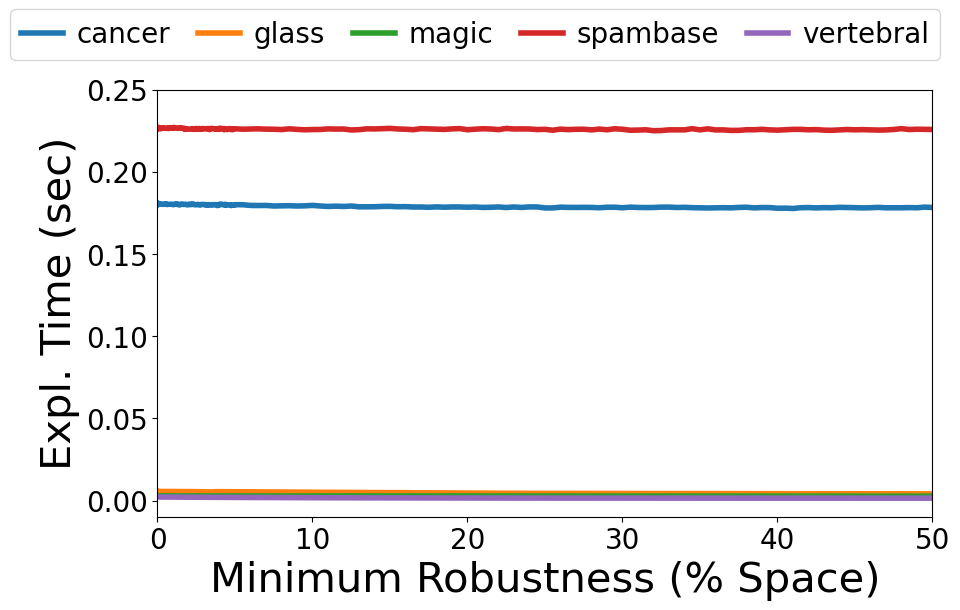

In [18]:
render_plot(xfeature="min_robust", yfeature="sample_time", xlabel="Minimum Robustness (% Space)", ylabel="Expl. Time (sec)", title=None, save_name="robustness_texplain", yticks=[0, 0.05, 0.1, 0.15, 0.2, 0.25], xrange=[0,50])

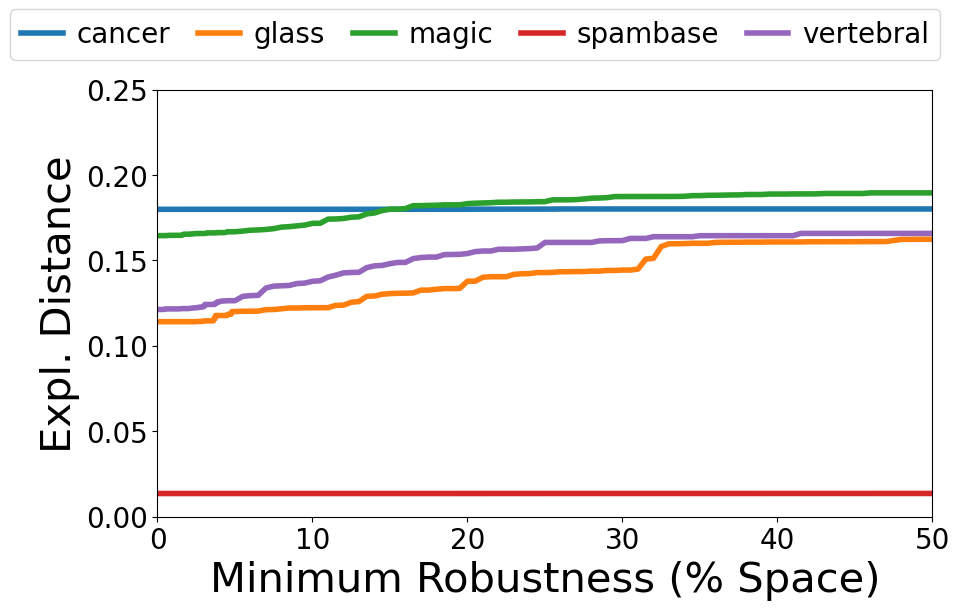

In [19]:
render_plot(xfeature="min_robust", yfeature="avg_dist", xlabel="Minimum Robustness (% Space)", ylabel="Expl. Distance", title=None, save_name="robustness_distance", yticks=[0, 0.05, 0.1, 0.15, 0.2, 0.25], xrange=[0,50])

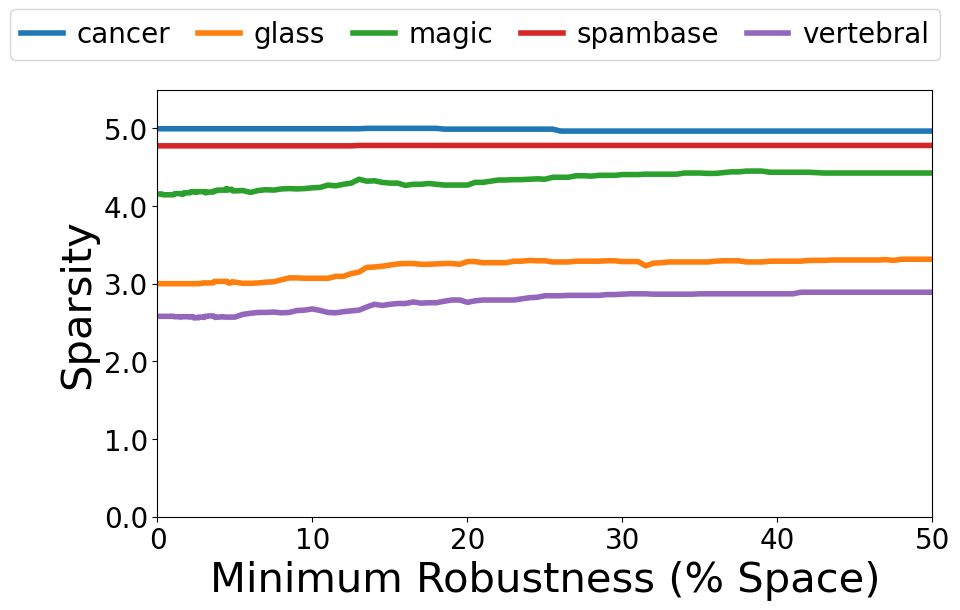

In [20]:
render_plot(xfeature="min_robust", yfeature="avg_length", xlabel="Minimum Robustness (% Space)", ylabel="Sparsity", title=None, save_name="robustness_sparsity", yrange=[0,5.5], xrange=[0,50])

In [21]:
# title = None
# xlabel = "Minimum Robustness (% Space)"
# ylabel = "Expl. Time (sec)"
# lhorz = True
# loc = "upper center"
# xrange = None
# yrange = None
# ylog = False
# xlog = False

# for ds in results["dataset"].unique():
#         is_ds = results["dataset"] == ds
#         for expl in results["explainer"].unique():
#             is_expl = results["explainer"] == expl
#             matching_rows = is_ds & is_expl
#             ax.plot(results[matching_rows][xfeature] * 100, results[matching_rows][yfeature], label=ds, lw=line_width, marker=ds_markers[ds], ms=marker_sizes[ds], color=ds_colors[ds])

#         # title and axis labels
#         if title is not None:
#             plt.title(title)
#         plt.xlabel(xlabel,fontsize=30)
#         plt.ylabel(ylabel,fontsize=30)
#         # legend
#         if lhorz:
#             plt.legend(loc=loc, ncol=len(results["dataset"].unique()), bbox_to_anchor=(0, 1.22, 0.82, 0), handletextpad=0.5, columnspacing=1, handlelength=1.5, prop={"size":20})
#         else:
#             plt.legend(loc=loc)
#         # x and y ranges
#         if xrange is not None:
#             plt.xlim(xrange)
#         if yrange is not None:
#             plt.ylim(yrange)
#         # x and y scales
#         if ylog:
#             plt.yscale('log')
#         if xlog:
#             plt.xscale('log')
#         plt.subplots_adjust(top=1.0)
#         plt.xticks(fontsize=20)
#         plt.yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25])
#         plt.yticks(fontsize=20)
#         # plt.xticks(np.arange(2, 22, 2))

# plt.savefig("distance_robust.png", bbox_inches="tight")

In [22]:
# # create viz
# fig = plt.figure(figsize=[10, 4.8], frameon=True)
# ax = fig.add_subplot(1, 1, 1)
# results = df_grouped
# xfeature = "min_robust"
# yfeature = "sample_time"
# line_width = 2
# cmap = plt.get_cmap("tab10")
# colors = cmap.colors
# ds_colors = {
#     "cancer": colors[0],
#     "glass": colors[1],
#     "magic": colors[2],
#     "spambase": colors[3],
#     "vertebral": colors[4]
# }
# ds_markers = {
#     "cancer": "^",
#     "glass": "o",
#     "magic": "v",
#     "spambase": "s",
#     "vertebral": "D"
# }
# marker_size = 0
# line_width = 4
# marker_sizes = {
#     "cancer": marker_size,
#     "glass": marker_size,
#     "magic": marker_size,
#     "spambase": marker_size,
#     "vertebral": marker_size
# }
# title = None
# xlabel = "Minimum Robustness (% Space)"
# ylabel = "Expl. Time (sec)"
# lhorz = True
# loc = "upper center"
# xrange = None
# yrange = None
# ylog = False
# xlog = False

# for ds in results["dataset"].unique():
#         is_ds = results["dataset"] == ds
#         for expl in results["explainer"].unique():
#             is_expl = results["explainer"] == expl
#             matching_rows = is_ds & is_expl
#             ax.plot(results[matching_rows][xfeature] * 100, results[matching_rows][yfeature], label=ds, lw=line_width, marker=ds_markers[ds], ms=marker_sizes[ds], color=ds_colors[ds])

#         # title and axis labels
#         if title is not None:
#             plt.title(title)
#         plt.xlabel(xlabel,fontsize=30)
#         plt.ylabel(ylabel,fontsize=30)
#         # legend
#         if lhorz:
#             plt.legend(loc=loc, ncol=len(results["dataset"].unique()), bbox_to_anchor=(0, 1.22, 0.82, 0), handletextpad=0.5, columnspacing=1, handlelength=1.5, prop={"size":20})
#         else:
#             plt.legend(loc=loc)
#         # x and y ranges
#         if xrange is not None:
#             plt.xlim(xrange)
#         if yrange is not None:
#             plt.ylim(yrange)
#         # x and y scales
#         if ylog:
#             plt.yscale('log')
#         if xlog:
#             plt.xscale('log')
#         plt.subplots_adjust(top=1.0)
#         plt.xticks(fontsize=20)
#         plt.yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25])
#         plt.yticks(fontsize=20)
#         # plt.xticks(np.arange(2, 22, 2))

# plt.savefig("runtime_robust.png", bbox_inches="tight")
